In [1]:
!pip3 install jiwer
!pip3 install jieba
!pip install opencc-python-reimplemented
!pip install cn2an

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import jiwer
import jieba
import re
import opencc
import matplotlib.pyplot as plt
import cn2an
import seaborn as sns
from scipy import stats

## Construct dataframe


In [2]:
df_A_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_A.csv', index_col=0, skipinitialspace=True)
df_B_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/D00XX_B.csv', index_col=0, skipinitialspace=True)
df_P_cleaned = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/data/P00XX.csv', index_col=0, skipinitialspace=True)
df_A_cleaned['file'] = df_A_cleaned['file'].str.extract(r'/(D\d{4}_A)', expand=False)
df_B_cleaned['file'] = df_B_cleaned['file'].str.extract(r'/(D\d{4}_B)', expand=False)
df_P_cleaned['file'] = df_P_cleaned['file'].str.extract(r'/(P\d{4})', expand=False)

df_cleaned = pd.concat([df_A_cleaned, df_B_cleaned, df_P_cleaned])
df_cleaned['start_time'] = df_cleaned['start_time'].astype(float)
df_cleaned['end_time'] = df_cleaned['end_time'].astype(float)
df_cleaned = df_cleaned.drop(columns=['participant'])
df_cleaned = df_cleaned.drop_duplicates()

df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"[，。]", "", x)))
df_cleaned = df_cleaned.assign(ground_truth_cleaned=df_cleaned['ground_truth_cleaned'].apply(lambda x: re.sub(r"<.*?>", "", x)))
    
df_model = pd.read_csv(f'/projectnb/ds549/projects/AImpower/datasets/generated-transcripts/Wav2vec.csv', index_col=0, skipinitialspace=True)
df_model = df_model.rename(columns={'Filename': 'file', 'Start_time': 'start_time', 'End_time': 'end_time'})
df_model['start_time'] = df_model['start_time'].astype(float)
df_model['end_time'] = df_model['end_time'].astype(float)
df_model = df_model.drop_duplicates()

df_merged = pd.merge(df_cleaned, df_model, on=['file', 'start_time', 'end_time'], how='outer')

df_merged = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, str))]
df_merged = df_merged[df_merged['Wav2vec'].apply(lambda x: isinstance(x, str))]
# ground_truth_cleaned == ""    10+ pieces
df_merged = df_merged[df_merged['ground_truth_cleaned']!=""]

In [3]:
#ground_truth include English
# df_merged = df_merged.assign(include_english = df_merged['ground_truth_cleaned'].apply(lambda x: bool(re.search(r'\b[a-zA-Z]+\b', x))))
# data_english = df_merged[df_merged['include_english']==True]
# data_english.to_csv('english.csv')

In [4]:
#clean data for predicted transcription
#transfer from traditional to simple
converter = opencc.OpenCC('t2s')  
df_merged = df_merged.assign(Whisper_large=df_merged['Wav2vec'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(Whisper_large = df_merged['Wav2vec'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(Whisper_large = df_merged['Wav2vec'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [5]:
#ground_truth_cleaned_with_repetition 
mask_pattern = r"\<.*?\>"
annotation_pattern = r"/\w"

df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth'].apply(lambda x: re.sub(mask_pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(annotation_pattern, "", x)))

#transfer from traditional to simple
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: converter.convert(x)))
#clean puactuation and transfer numbers
pattern  = r"[\s\W]"
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: re.sub(pattern, "", x)))
df_merged = df_merged.assign(ground_truth_cleaned_with_repetition = df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: cn2an.transform(x, "an2cn")))

In [6]:
df_merged

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Wav2vec,Whisper_large,ground_truth_cleaned_with_repetition
0,D0001_A,87.970,94.850,大/r[大]家好，我是叫<姓名>，那。,大家好我是叫那,他他大家好过四教马,他他大家好过四教马,大大家好我是叫那
1,D0001_A,95.580,102.830,我是，今年是，<年龄>岁来自<居住地>，呃/i。,我是今年是岁来自,我是金阳市来,我是金阳市来,我是今年是岁来自呃
2,D0001_A,104.090,105.680,我是。,我是,我讯,我讯,我是
3,D0001_A,106.300,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,兹森的考考兹汉者,兹森的考考兹汉者,资深的口口吃患者
4,D0001_A,119.130,124.490,我是从小就有口吃。,我是从小就有口吃,是从小就有口吃,是从小就有口吃,我是从小就有口吃
...,...,...,...,...,...,...,...,...
37245,P0070,3032.636,3035.926,你好，米雅，拿日元换法郎怎么换。,你好米雅拿日元换法郎怎么换,你豪米亚拿日员换法郎怎办,你豪米亚拿日员换法郎怎办,你好米雅拿日元换法郎怎么换
37246,P0070,3037.766,3041.436,你好，米雅，六百五十韩元是多少法郎。,你好米雅六百五十韩元是多少法郎,你豪米亚六百五十韩员是多少法了,你豪米亚六百五十韩员是多少法了,你好米雅六百五十韩元是多少法郎
37247,P0070,3043.086,3045.546,你好，米雅，添加日程。,你好米雅添加日程,你好米亚添加日测,你好米亚添加日测,你好米雅添加日程
37248,P0070,3049.256,3053.116,我觉得推翻现有数学体系不是那么不可思议了。,我觉得推翻现有数学体系不是那么不可思议了,我觉得推盘现有数学体系不是那么不可思议了,我觉得推盘现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了


In [7]:
# df_merged_a = df_merged[df_merged['Whisper_large'].apply(lambda x: isinstance(x, float))]
# df_merged_a
# df_merged_b = df_merged[df_merged['ground_truth_cleaned'].apply(lambda x: isinstance(x, float))]
# df_merged_b

In [8]:
#without repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned'].iloc[i]
    hypothesis = df_merged['Wav2vec'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER'] = WER
df_merged['CER'] = CER

#with repetition
#word/character error rate
WER = []
CER = []
#word/character error count
# WEC = []
# CEC = []

for i in range(df_merged.shape[0]):
    reference = df_merged['ground_truth_cleaned_with_repetition'].iloc[i]
    hypothesis = df_merged['Wav2vec'].iloc[i]
    if not isinstance(reference, str) or not isinstance(hypothesis, str):
        WER.append(np.nan)
        CER.append(np.nan)
    else:
#         print(' '.join(jieba.lcut(reference)),"COMPARE", ' '.join(jieba.lcut(hypothesis)))
#         print(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
#         print(jiwer.cer(reference, hypothesis))
        WER.append(jiwer.wer(' '.join(jieba.lcut(reference)), ' '.join(jieba.lcut(hypothesis))))
        CER.append(jiwer.cer(reference, hypothesis))

df_merged['WER_repetition'] = WER
df_merged['CER_repetition'] = CER

Building prefix dict from the default dictionary ...
Loading model from cache /scratch/1407865.1.academic-gpu/jieba.cache
Loading model cost 0.515 seconds.
Prefix dict has been built successfully.


In [9]:
repetition_pattern = r"\[.*?\]"
annotation_pattern = r"/\w"

df_merged = df_merged.assign(stutterance_count=df_merged['ground_truth'].apply(lambda x: len(re.findall(repetition_pattern, x)) + len(re.findall(annotation_pattern, x))))
df_merged = df_merged.assign(character_count=df_merged['ground_truth_cleaned'].apply(lambda x: len(x)))
df_merged = df_merged.assign(character_count_repetition=df_merged['ground_truth_cleaned_with_repetition'].apply(lambda x: len(x)))
df_merged['stutterance_frequency'] = df_merged['stutterance_count']/df_merged['character_count']

In [10]:
df_merged['duration'] = df_merged['end_time']-df_merged['start_time']

In [11]:
#delete data with mask
# df_merged = df_merged.assign(mask = df_merged['ground_truth'].apply(lambda x: bool(re.search(r'<[^<>]*[\u4e00-\u9fff]+[^<>]*>', x))))
# df_merged = df_merged[df_merged['mask']==False]
# df_merged = df_merged.drop('mask', axis=1)

In [12]:
df_merged

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Wav2vec,Whisper_large,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
0,D0001_A,87.970,94.850,大/r[大]家好，我是叫<姓名>，那。,大家好我是叫那,他他大家好过四教马,他他大家好过四教马,大大家好我是叫那,1.000000,0.857143,1.000000,0.750000,2,7,8,0.285714,6.88
1,D0001_A,95.580,102.830,我是，今年是，<年龄>岁来自<居住地>，呃/i。,我是今年是岁来自,我是金阳市来,我是金阳市来,我是今年是岁来自呃,0.666667,0.625000,0.714286,0.666667,1,8,9,0.125000,7.25
2,D0001_A,104.090,105.680,我是。,我是,我讯,我讯,我是,1.000000,0.500000,1.000000,0.500000,0,2,2,0.000000,1.59
3,D0001_A,106.300,119.120,资深/p的口/b[口/r/b]吃患者。,资深的口吃患者,兹森的考考兹汉者,兹森的考考兹汉者,资深的口口吃患者,0.750000,0.857143,0.800000,0.750000,5,7,8,0.714286,12.82
4,D0001_A,119.130,124.490,我是从小就有口吃。,我是从小就有口吃,是从小就有口吃,是从小就有口吃,我是从小就有口吃,0.166667,0.125000,0.166667,0.125000,0,8,8,0.000000,5.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37245,P0070,3032.636,3035.926,你好，米雅，拿日元换法郎怎么换。,你好米雅拿日元换法郎怎么换,你豪米亚拿日员换法郎怎办,你豪米亚拿日员换法郎怎办,你好米雅拿日元换法郎怎么换,0.875000,0.384615,0.875000,0.384615,0,13,13,0.000000,3.29
37246,P0070,3037.766,3041.436,你好，米雅，六百五十韩元是多少法郎。,你好米雅六百五十韩元是多少法郎,你豪米亚六百五十韩员是多少法了,你豪米亚六百五十韩员是多少法了,你好米雅六百五十韩元是多少法郎,0.857143,0.266667,0.857143,0.266667,0,15,15,0.000000,3.67
37247,P0070,3043.086,3045.546,你好，米雅，添加日程。,你好米雅添加日程,你好米亚添加日测,你好米亚添加日测,你好米雅添加日程,0.500000,0.250000,0.500000,0.250000,0,8,8,0.000000,2.46
37248,P0070,3049.256,3053.116,我觉得推翻现有数学体系不是那么不可思议了。,我觉得推翻现有数学体系不是那么不可思议了,我觉得推盘现有数学体系不是那么不可思议了,我觉得推盘现有数学体系不是那么不可思议了,我觉得推翻现有数学体系不是那么不可思议了,0.100000,0.050000,0.100000,0.050000,0,20,20,0.000000,3.86


In [13]:
df_merged.to_csv('Wav2vec_evaluation.csv')

## Analysis

In [14]:
data = pd.read_csv('/projectnb/ds549/projects/AImpower/evaluation-wav2vec/Wav2vec_evaluation.csv', index_col=0)

In [15]:
data.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
count,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000,36625.000000
mean,1988.660211,1993.482369,0.510520,0.328909,0.463933,0.296159,1.024874,15.083686,15.906239,0.071653,4.822158
std,1026.091340,1024.200212,0.465142,0.310697,0.410493,0.270982,1.712107,13.683855,14.459380,0.162063,3.746952
min,0.490000,0.840000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.260000
25%,1144.420000,1152.080000,0.200000,0.120000,0.176471,0.105263,0.000000,5.000000,5.000000,0.000000,1.980000
50%,2126.570000,2129.542000,0.428571,0.250000,0.388889,0.235294,0.000000,10.000000,10.000000,0.000000,3.400000
75%,2780.765000,2784.738000,0.714286,0.478261,0.666667,0.428571,1.000000,21.000000,22.000000,0.086957,6.890000
max,4157.869000,4168.639000,8.000000,5.000000,13.000000,5.000000,17.000000,118.000000,126.000000,5.000000,32.330000


### Overall Analysis 

In [16]:
#find outliers manually
data[data['WER']>3]
data[data['CER']>3]
# data = data[data['Whisper_large'].str.contains('转发打赏')!=True]
# data = data[data['Whisper_large'].str.contains('中文字幕')!=True]
#deleted mask data
#mask 在structure里删除了
#8535	D0062_A	39.210	42.990 mask需手动删除
#786	D0006_A	1571.400000	1571.920 无特殊问题
#21617	P0019	2929.924000	2930.744 无特殊问题
#6648	D0048_A	1387.060	1387.950 音频有一些截断问题？不算
#8032	D0057_A	1735.290	1736.820 无特殊问题

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Wav2vec,Whisper_large,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration
1198,D0010_A,1291.240,1292.510,对/r[对对对对]。,对,四自自治镇,四自自治镇,对对对对对,4.000000,5.000000,1.000000,1.000000,2,1,5,2.000000,1.27
1216,D0010_A,1505.880,1507.720,<overlap>对[对对对]。,对,然好对对组队,然好对对组队,对对对对,3.000000,5.000000,0.500000,1.000000,1,1,4,1.000000,1.84
3405,D0027_A,944.500,945.590,能[能能能]。,能,拿到脑上,拿到脑上,能能能能,2.000000,4.000000,1.000000,1.000000,1,1,4,1.000000,1.09
5068,D0037_A,936.290,947.480,贵[贵贵贵/r贵贵贵贵贵贵/r贵/b/r贵贵/r/b贵]州啊等/r等的，嗯/i/p。,贵州啊等等的,故过过故顾不估过过怪过归归不估过过贵柔啊的党老了,故过过故顾不估过过怪过归归不估过过贵柔啊的党老了,贵贵贵贵贵贵贵贵贵贵贵贵贵贵州啊等等的嗯,4.500000,3.666667,1.636364,1.100000,10,6,20,1.666667,11.19
5154,D0037_A,1841.830,1851.110,有[有]点逃[逃/r逃/r逃逃逃逃逃]避，社[社社社社社社社社社社]交。,有点逃避社交,有犹尔陶塔塔塔塔利特设社是设圣特设是设施二热,有犹尔陶塔塔塔塔利特设社是设圣特设是设施二热,有有点逃逃逃逃逃逃逃逃避社社社社社社社社社社社交,3.666667,3.333333,0.937500,0.916667,5,6,24,0.833333,9.28
17873,P0010,2152.106,2156.666,除[除除除除除]尘[尘]。,除尘,出出出出出陈程,出出出出出陈程,除除除除除除尘尘,4.000000,3.500000,1.000000,1.000000,2,2,8,1.000000,4.56
17876,P0010,2172.406,2175.126,停[停停停停停]。,停,天七停停停停,天七停停停停,停停停停停停,3.000000,5.000000,0.333333,0.333333,1,1,6,1.000000,2.72
17965,P0010,2919.856,2923.426,低[低低低]音/r[音]。,低音,第一弟地第一音音,第一弟地第一音音,低低低低音音,4.000000,3.500000,1.000000,1.000000,3,2,6,1.500000,3.57
18568,P0011,3521.242,3524.932,噩梦[噩梦噩梦]。,噩梦,阿尔穆阿穆尔穆,阿尔穆阿穆尔穆,噩梦噩梦噩梦,3.000000,3.500000,1.000000,1.166667,1,2,6,0.500000,3.69


In [17]:
data = data.assign(z_scores = data['CER'].apply(lambda x: (x-data['CER'].mean())/data['CER'].std()))
data_normal = data[data['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER'].apply(lambda x: (x-data_normal['WER'].mean())/data_normal['WER'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['WER_repetition'].apply(lambda x: (x-data_normal['WER_repetition'].mean())/data_normal['WER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_normal = data_normal.assign(z_scores = data_normal['CER_repetition'].apply(lambda x: (x-data_normal['CER_repetition'].mean())/data_normal['CER_repetition'].std()))
data_normal = data_normal[data_normal['z_scores']<3]
data_outliers = data[~data.index.isin(data_normal.index)]
data.drop('z_scores', axis=1)
data_outliers

,file,start_time,end_time,ground_truth,ground_truth_cleaned,Wav2vec,Whisper_large,ground_truth_cleaned_with_repetition,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores
8,D0001_A,150.850,154.010,那我是。,那我是,长波尔尔,长波尔尔,那我是,1.000000,1.333333,1.000000,1.333333,0,3,3,0.000000,3.16,3.232808
154,D0002_A,745.940,747.120,嗯对的。,嗯对的,你你睡了,你你睡了,嗯对的,1.333333,1.333333,1.333333,1.333333,0,3,3,0.000000,1.18,3.232808
489,D0004_A,1071.450,1075.420,<overlap>super/r hero，super hero。,super herosuper hero,现在主主黑若主和黑物,现在主主黑若主和黑物,superherosuperhero,1.666667,1.000000,5.000000,1.000000,1,20,18,0.050000,3.97,2.159952
504,D0004_A,1290.180,1293.820,绯[绯]<overlap>红，绯[绯]红女巫。,绯红绯红女巫,水色水化为彩洪绿翁,水色水化为彩洪绿翁,绯绯红绯绯红女巫,1.333333,1.500000,1.000000,1.125000,2,6,8,0.333333,3.64,3.769236
688,D0006_A,155.280,157.020,然[然]后<overlap>的话。,然后的话,奥代物独霍二子,奥代物独霍二子,然然后的话,1.000000,1.750000,1.000000,1.400000,1,4,5,0.250000,1.74,4.573878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37033,P0070,2160.316,2161.696,除甲醛。,除甲醛,出甲醛,出甲醛,除甲醛,2.000000,0.333333,2.000000,0.333333,0,3,3,0.000000,1.38,0.014240
37131,P0070,2558.696,2560.336,播放小小蜡笔。,播放小小蜡笔,播播放小傻蜡比,播播放小傻蜡比,播放小小蜡笔,1.666667,0.500000,1.666667,0.500000,0,6,6,0.000000,1.64,0.550668
37163,P0070,2685.886,2687.046,霸王别姬。,霸王别姬,霸王列击,霸王列击,霸王别姬,2.000000,0.500000,2.000000,0.500000,0,4,4,0.000000,1.16,0.550668
37164,P0070,2688.496,2689.426,无间道。,无间道,吴见道,吴见道,无间道,2.000000,0.666667,2.000000,0.666667,0,3,3,0.000000,0.93,1.087096


In [33]:
data_outliers.to_csv('outliers.csv')

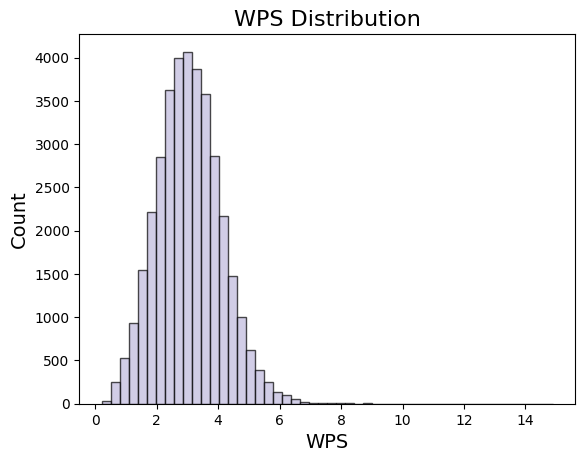

In [18]:
#speed
data['WPS'] = data['character_count']/data['duration']
plt.hist(data['WPS'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("WPS Distribution", fontsize=16)
plt.xlabel("WPS", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

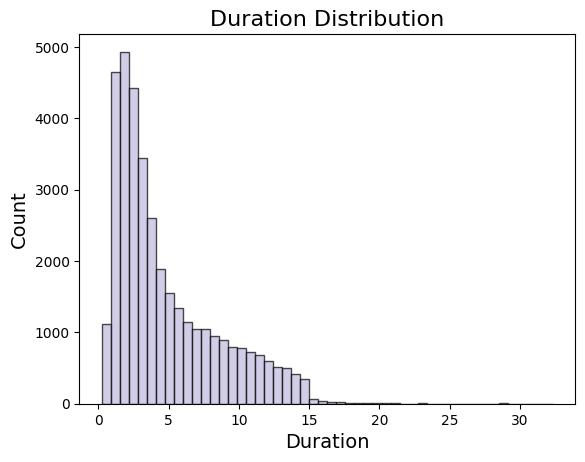

In [19]:
#duration
plt.hist(data['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [20]:
#correlation
data_number = data[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_cor_spearman = data_number.corr(method="spearman")
data_cor_pearson = data_number.corr()

In [21]:
data_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.779587,0.860543,0.698004,0.055387,-0.244660,-0.217446,0.332353,-0.167710,-0.234573
CER,0.779587,1.000000,0.695484,0.906180,0.097095,-0.219500,-0.187422,0.399957,-0.141900,-0.230775
WER_repetition,0.860543,0.695484,1.000000,0.770337,-0.068906,-0.236716,-0.232733,0.098752,-0.211847,-0.124349
CER_repetition,0.698004,0.906180,0.770337,1.000000,-0.027078,-0.224002,-0.214941,0.167627,-0.193895,-0.139036
stutterance_count,0.055387,0.097095,-0.068906,-0.027078,1.000000,0.464062,0.536897,0.612941,0.677187,-0.175419
character_count,-0.244660,-0.219500,-0.236716,-0.224002,0.464062,1.000000,0.993245,-0.025215,0.892876,0.418651
character_count_repetition,-0.217446,-0.187422,-0.232733,-0.214941,0.536897,0.993245,1.000000,0.035244,0.911800,0.378271
stutterance_frequency,0.332353,0.399957,0.098752,0.167627,0.612941,-0.025215,0.035244,1.000000,0.195056,-0.417086
duration,-0.167710,-0.141900,-0.211847,-0.193895,0.677187,0.892876,0.911800,0.195056,1.000000,0.072000
WPS,-0.234573,-0.230775,-0.124349,-0.139036,-0.175419,0.418651,0.378271,-0.417086,0.072000,1.000000


In [22]:
data_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.908617,0.943469,0.867690,0.039971,-0.229989,-0.194965,0.116187,-0.148088,-0.188294
CER,0.908617,1.000000,0.864254,0.947574,0.102506,-0.171674,-0.133324,0.167777,-0.096878,-0.158292
WER_repetition,0.943469,0.864254,1.000000,0.915959,-0.047718,-0.222091,-0.206893,0.007835,-0.174410,-0.129212
CER_repetition,0.867690,0.947574,0.915959,1.000000,0.009729,-0.173250,-0.154741,0.056925,-0.130257,-0.104848
stutterance_count,0.039971,0.102506,-0.047718,0.009729,1.000000,0.528500,0.598681,0.953038,0.691125,-0.125921
character_count,-0.229989,-0.171674,-0.222091,-0.173250,0.528500,1.000000,0.989802,0.359632,0.899777,0.472001
character_count_repetition,-0.194965,-0.133324,-0.206893,-0.154741,0.598681,0.989802,1.000000,0.442013,0.924324,0.418833
stutterance_frequency,0.116187,0.167777,0.007835,0.056925,0.953038,0.359632,0.442013,1.000000,0.564197,-0.255434
duration,-0.148088,-0.096878,-0.174410,-0.130257,0.691125,0.899777,0.924324,0.564197,1.000000,0.085435
WPS,-0.188294,-0.158292,-0.129212,-0.104848,-0.125921,0.472001,0.418833,-0.255434,0.085435,1.000000


### Stutter VS non-Stutter

In [23]:
data_stutter = data[data['stutterance_count']>0]
data_non_stutter = data[data['stutterance_count']==0]

In [24]:
data_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,WPS
count,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000,15043.000000
mean,1455.009144,1462.662662,0.531941,0.357582,0.419683,0.280586,2.495247,23.281127,25.356312,0.174452,7.653519,0.092285,2.898548
std,974.048499,972.636771,0.486340,0.329245,0.333683,0.227280,1.862234,15.468515,15.988208,0.214507,3.821733,1.059697,1.077374
min,0.490000,6.210000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.011628,0.540000,-1.058616,0.216920
25%,643.750000,654.540000,0.250000,0.160000,0.214286,0.129032,1.000000,10.000000,11.000000,0.062500,4.530000,-0.543645,2.083333
50%,1298.390000,1307.240000,0.409091,0.266667,0.346154,0.222222,2.000000,21.000000,23.000000,0.111111,7.330000,-0.200331,2.930832
75%,2176.945500,2181.992500,0.666667,0.454545,0.555556,0.372549,3.000000,34.000000,37.000000,0.200000,10.495000,0.404370,3.677845
max,4157.869000,4168.639000,8.000000,5.000000,13.000000,3.000000,17.000000,118.000000,126.000000,5.000000,32.330000,15.034224,7.976366


In [25]:
data_non_stutter.describe()

,start_time,end_time,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,z_scores,WPS
count,21582.000000,21582.000000,21582.000000,21582.000000,21582.000000,21582.000000,21582.0,21582.000000,21582.000000,21582.0,21582.000000,21582.000000,21582.000000
mean,2360.623561,2363.472215,0.495589,0.308924,0.494777,0.307014,0.0,9.369938,9.319387,0.0,2.848654,-0.064324,3.187791
std,888.028290,887.409045,0.449184,0.295452,0.453913,0.297195,0.0,8.456055,8.426195,0.0,2.040329,0.950931,1.021935
min,0.500000,0.840000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,0.0,0.260000,-1.058616,0.494234
25%,1915.926000,1918.434250,0.125000,0.076923,0.117647,0.071429,0.0,4.000000,4.000000,0.0,1.530000,-0.811034,2.475248
50%,2447.963000,2450.694500,0.444444,0.250000,0.428571,0.250000,0.0,7.000000,7.000000,0.0,2.330000,-0.253974,3.086420
75%,3002.862750,3005.723250,0.750000,0.500000,0.750000,0.500000,0.0,11.000000,11.000000,0.0,3.420000,0.550668,3.787879
max,4153.299000,4157.799000,4.000000,3.000000,4.000000,5.000000,0.0,79.000000,79.000000,0.0,20.070000,8.597088,14.893617


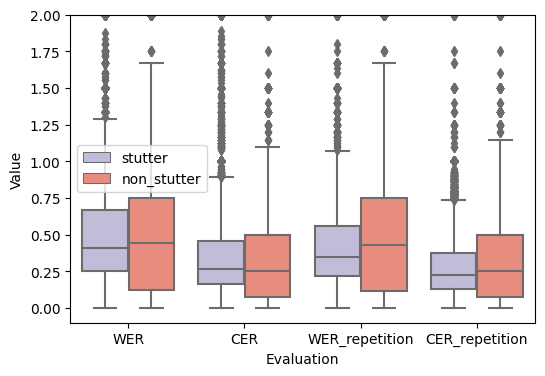

In [26]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 2) 
plt.title("")
plt.legend()
plt.show()

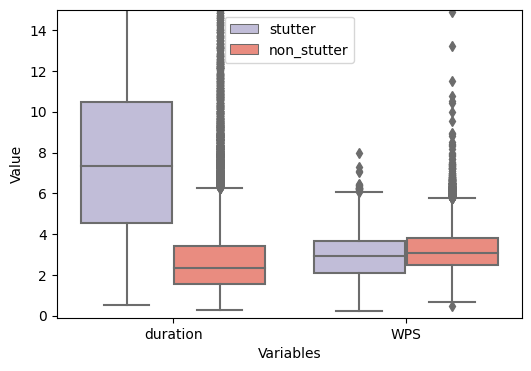

In [27]:
data_stutter_number = data_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_stutter_number['Group'] = 'stutter'
data_non_stutter_number = data_non_stutter[['duration', 'WPS']].melt(var_name='Variables', value_name='Value')
data_non_stutter_number['Group'] = 'non_stutter'
combined_data = pd.concat([data_stutter_number, data_non_stutter_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F']
sns.boxplot(data=combined_data, x='Variables', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 15) 
plt.title("")
plt.legend()
plt.show()

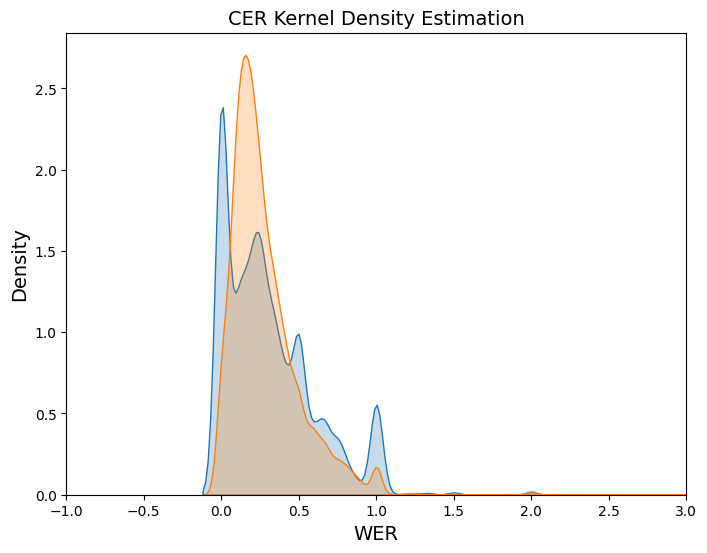

In [28]:
#CER
plt.figure(figsize=(8, 6))
sns.kdeplot(data_non_stutter['CER'], label='non_stutter', fill=True)
sns.kdeplot(data_stutter['CER_repetition'], label='stutter', fill=True)

plt.title("CER Kernel Density Estimation", fontsize=14)
plt.xlim(-1,3)
plt.xlabel('WER', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

### non-Stutter

In [29]:
#non-stutter data
data_non_stutter_number = data_non_stutter[['WER','CER','WER_repetition','CER_repetition','character_count','character_count_repetition','duration', 'WPS']]
data_non_stutter_cor_pearson = data_non_stutter_number.corr()
data_non_stutter_cor_spearman = data_non_stutter_number.corr(method = 'spearman')

In [30]:
data_non_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.762857,0.995271,0.759201,-0.183399,-0.185487,-0.186688,-0.062194
CER,0.762857,1.000000,0.763756,0.996829,-0.181393,-0.185544,-0.203032,-0.046320
WER_repetition,0.995271,0.763756,1.000000,0.763095,-0.184236,-0.186177,-0.187956,-0.057196
CER_repetition,0.759201,0.996829,0.763095,1.000000,-0.183460,-0.186701,-0.203556,-0.052322
character_count,-0.183399,-0.181393,-0.184236,-0.183460,1.000000,0.999513,0.913691,0.444284
character_count_repetition,-0.185487,-0.185544,-0.186177,-0.186701,0.999513,1.000000,0.914323,0.439825
duration,-0.186688,-0.203032,-0.187956,-0.203556,0.913691,0.914323,1.000000,0.138621
WPS,-0.062194,-0.046320,-0.057196,-0.052322,0.444284,0.439825,0.138621,1.000000


In [31]:
data_non_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,character_count,character_count_repetition,duration,WPS
WER,1.000000,0.907606,0.997875,0.907629,-0.145969,-0.151371,-0.157565,-0.041819
CER,0.907606,1.000000,0.905191,0.998269,-0.124833,-0.132432,-0.154878,-0.006665
WER_repetition,0.997875,0.905191,1.000000,0.908260,-0.146924,-0.151243,-0.157200,-0.044081
CER_repetition,0.907629,0.998269,0.908260,1.000000,-0.128816,-0.134884,-0.156352,-0.011881
character_count,-0.145969,-0.124833,-0.146924,-0.128816,1.000000,0.998812,0.882869,0.533890
character_count_repetition,-0.151371,-0.132432,-0.151243,-0.134884,0.998812,1.000000,0.884672,0.529104
duration,-0.157565,-0.154878,-0.157200,-0.156352,0.882869,0.884672,1.000000,0.119387
WPS,-0.041819,-0.006665,-0.044081,-0.011881,0.533890,0.529104,0.119387,1.000000


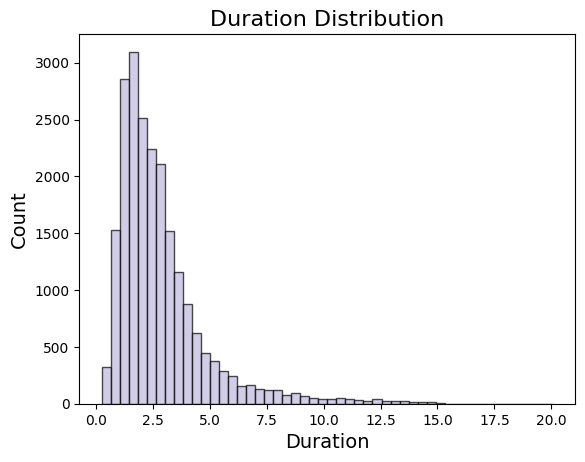

count    21582.000000
mean         2.848654
std          2.040329
min          0.260000
25%          1.530000
50%          2.330000
75%          3.420000
max         20.070000
Name: duration, dtype: float64

In [32]:
#duration
plt.hist(data_non_stutter['duration'], bins = 50, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Duration Distribution", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

data_non_stutter['duration'].describe()

In [33]:
data_non_stutter_long = data_non_stutter[data_non_stutter['duration'] > 7.5]
data_non_stutter_medium = data_non_stutter[data_non_stutter['duration'] > 3.38]
data_non_stutter_medium = data_non_stutter_medium[data_non_stutter_medium['duration'] <= 7.5]
data_non_stutter_short = data_non_stutter[data_non_stutter['duration']<=3.38]

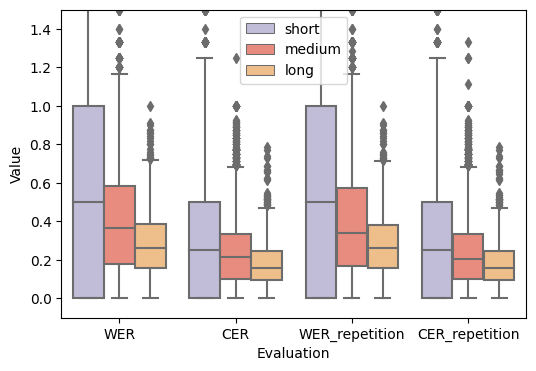

In [34]:
data_non_stutter_long_number = data_non_stutter_long[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_long_number['Group'] = 'long'
data_non_stutter_medium_number = data_non_stutter_medium[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_medium_number['Group'] = 'medium'
data_non_stutter_short_number = data_non_stutter_short[['WER','CER','WER_repetition','CER_repetition']].melt(var_name='Evaluation', value_name='Value')
data_non_stutter_short_number['Group'] = 'short'
combined_data = pd.concat([data_non_stutter_short_number,data_non_stutter_medium_number, data_non_stutter_long_number])

fig,ax = plt.subplots(figsize=(6, 4))
custom_palette = ['#BEB8DC', '#FA7F6F', "#FFBE7A"]
sns.boxplot(data=combined_data, x='Evaluation', y='Value', hue='Group', palette=custom_palette, ax=ax)
ax.set_ylim(-0.1, 1.5) 
plt.title("")
plt.legend()
plt.show()

### Stutter

In [35]:
data_stutter_number = data_stutter[['WER','CER','WER_repetition','CER_repetition','stutterance_count','character_count','character_count_repetition','stutterance_frequency','duration', 'WPS']]
data_stutter_cor_spearman = data_stutter_number.corr(method='spearman')
data_stutter_cor_pearson = data_stutter_number.corr()

In [36]:
data_stutter_cor_spearman

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.915707,0.832186,0.774515,0.021505,-0.461251,-0.412400,0.463109,-0.330548,-0.410281
CER,0.915707,1.000000,0.796105,0.848961,0.058626,-0.415178,-0.358922,0.444311,-0.291019,-0.369245
WER_repetition,0.832186,0.796105,1.000000,0.923993,-0.000884,-0.343810,-0.320170,0.329820,-0.243089,-0.301250
CER_repetition,0.774515,0.848961,0.923993,1.000000,0.038626,-0.300773,-0.273510,0.317377,-0.207157,-0.262829
stutterance_count,0.021505,0.058626,-0.000884,0.038626,1.000000,0.287578,0.362448,0.441017,0.507487,-0.107138
character_count,-0.461251,-0.415178,-0.343810,-0.300773,0.287578,1.000000,0.988706,-0.692769,0.860022,0.729090
character_count_repetition,-0.412400,-0.358922,-0.320170,-0.273510,0.362448,0.988706,1.000000,-0.628210,0.880205,0.689338
stutterance_frequency,0.463109,0.444311,0.329820,0.317377,0.441017,-0.692769,-0.628210,1.000000,-0.407022,-0.759106
duration,-0.330548,-0.291019,-0.243089,-0.207157,0.507487,0.860022,0.880205,-0.407022,1.000000,0.313688
WPS,-0.410281,-0.369245,-0.301250,-0.262829,-0.107138,0.729090,0.689338,-0.759106,0.313688,1.000000


In [37]:
data_stutter_cor_pearson

,WER,CER,WER_repetition,CER_repetition,stutterance_count,character_count,character_count_repetition,stutterance_frequency,duration,WPS
WER,1.000000,0.799501,0.681071,0.627585,0.059560,-0.410760,-0.372582,0.548896,-0.306205,-0.444742
CER,0.799501,1.000000,0.647789,0.814365,0.088408,-0.396799,-0.350908,0.623451,-0.289596,-0.439122
WER_repetition,0.681071,0.647789,1.000000,0.788148,-0.012050,-0.311388,-0.305911,0.331327,-0.259539,-0.294336
CER_repetition,0.627585,0.814365,0.788148,1.000000,0.019547,-0.325466,-0.310969,0.423369,-0.261826,-0.320404
stutterance_count,0.059560,0.088408,-0.012050,0.019547,1.000000,0.208822,0.294887,0.394435,0.493462,-0.172417
character_count,-0.410760,-0.396799,-0.311388,-0.325466,0.208822,1.000000,0.990015,-0.472048,0.836614,0.694496
character_count_repetition,-0.372582,-0.350908,-0.305911,-0.310969,0.294887,0.990015,1.000000,-0.422095,0.856205,0.658643
stutterance_frequency,0.548896,0.623451,0.331327,0.423369,0.394435,-0.472048,-0.422095,1.000000,-0.250771,-0.622410
duration,-0.306205,-0.289596,-0.259539,-0.261826,0.493462,0.836614,0.856205,-0.250771,1.000000,0.266454
WPS,-0.444742,-0.439122,-0.294336,-0.320404,-0.172417,0.694496,0.658643,-0.622410,0.266454,1.000000


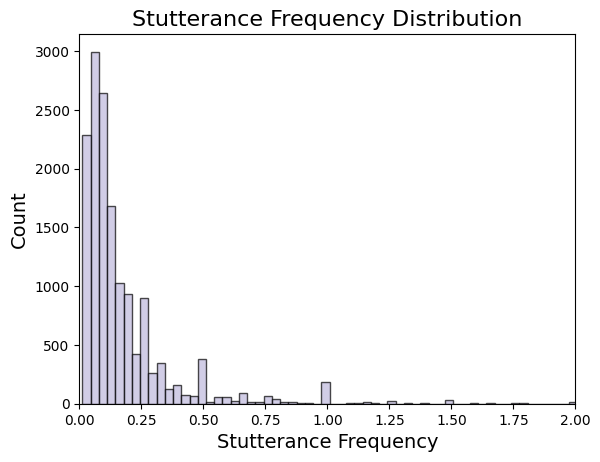

In [38]:
#stutterance frequency
plt.hist(data_stutter['stutterance_frequency'], bins = 150, color='#BEB8DC', edgecolor='black', alpha=0.7)
plt.title("Stutterance Frequency Distribution", fontsize=16)
plt.xlim(-0, 2)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

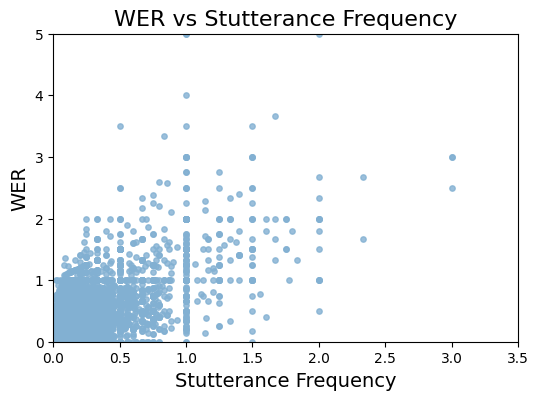

In [40]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data_stutter["stutterance_frequency"], 
    data_stutter["CER"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,3.5)
plt.ylim(0,5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

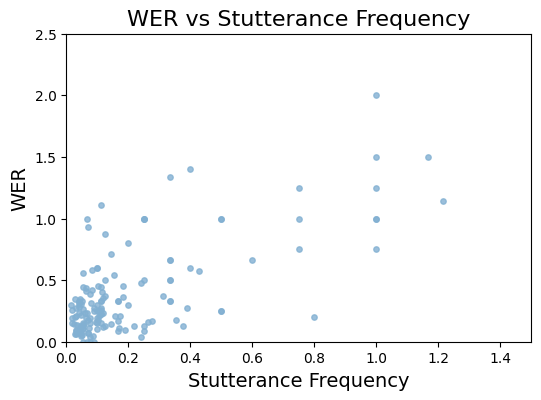

In [41]:
sampled_data_stutter = data_stutter.groupby('file').sample(frac=0.01, random_state=42)
plt.figure(figsize=(6, 4))
plt.scatter(
    sampled_data_stutter["stutterance_frequency"], 
    sampled_data_stutter["CER"], 
    s=15,
    alpha=0.8,
    color="#82B0D2"
)
plt.xlim(0,1.5)
plt.ylim(0,2.5)

plt.title("WER vs Stutterance Frequency", fontsize=16)
plt.xlabel("Stutterance Frequency", fontsize=14)
plt.ylabel("WER", fontsize=14)
# plt.grid(True)
plt.show()

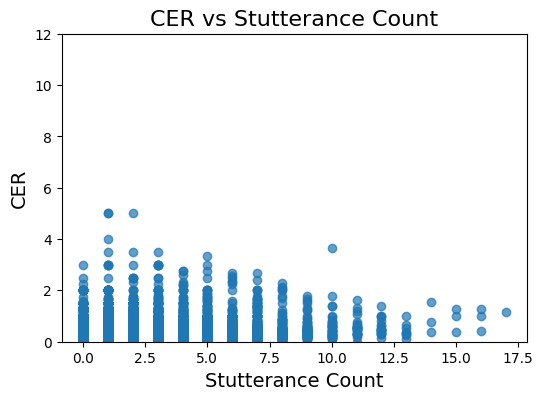

In [42]:
#stutterance count
plt.figure(figsize=(6, 4))
plt.scatter(
    data["stutterance_count"], 
    data["CER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("CER vs Stutterance Count", fontsize=16)
plt.ylim(0,12)
plt.xlabel("Stutterance Count", fontsize=14)
plt.ylabel("CER", fontsize=14)
plt.show()

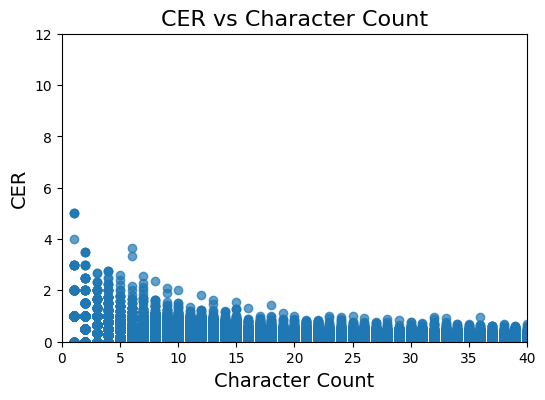

In [43]:
plt.figure(figsize=(6, 4))
plt.scatter(
    data["character_count"], 
    data["CER"], 
    alpha=0.7  # Handle overlapping points
)

plt.title("CER vs Character Count", fontsize=16)
plt.xlim(0,40)
plt.ylim(0,12)
plt.xlabel("Character Count", fontsize=14)
plt.ylabel("CER", fontsize=14)
plt.show()